In [300]:
import Pkg;
#Pkg.add("CSV")
#Pkg.add("Random")
#Pkg.add("PyPlot")
#Pkg.add("MLLabelUtils")
#Pkg.add("MLDataUtils")
#Pkg.add("DecisionTree")
#Pkg.add("ScikitLearn")
#Pkg.add("XGBoost")
#Pkg.add("PyCall")
#Pkg.add("MLBase")
#Pkg.add("LearnBase")

# Diagnosing Breast Cancer using Julia

##### Loading necessary packages and reading the [dataset](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data).

In [301]:
using CSV
using DataFrames
df = CSV.read("wdbc.csv");

##### Setting Random Seed to produce same output everytime, it helps in debugging

In [302]:
RANDOM_STATE = 100
using Random
Random.seed!(RANDOM_STATE)

MersenneTwister(UInt32[0x00000064], Random.DSFMT.DSFMT_state(Int32[-2036630343, 1072818225, 1299231502, 1073154435, 1563612565, 1073206618, 176198161, 1073683625, 381415896, 1073699088  …  163992627, 1073241259, 385818456, 1072878963, 399273729, 595433664, 390891112, 1704156657, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x0000000000000000

##### First 5 samples of the dataset

In [303]:
first(df,5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
,Int64,String,Float64,Float64,Float64,Float64,Float64
1,842302,M,17.99,10.38,122.8,1001.0,0.1184
2,842517,M,20.57,17.77,132.9,1326.0,0.08474
3,84300903,M,19.69,21.25,130.0,1203.0,0.1096
4,84348301,M,11.42,20.38,77.58,386.1,0.1425
5,84358402,M,20.29,14.34,135.1,1297.0,0.1003


#####  Printing the number of instances and number of columns

In [304]:
# size function returns the number of row and columns of the dataset
row, col = size(df)
println("Number of Instances: ", row)
println("Number of Columns: ", col)

Number of Instances: 569
Number of Columns: 32


##### Headers / Column names of the dataset

In [305]:
println(names(df))

Symbol[:id, :diagnosis, :radius_mean, :texture_mean, :perimeter_mean, :area_mean, :smoothness_mean, :compactness_mean, :concavity_mean, Symbol("concave points_mean"), :symmetry_mean, :fractal_dimension_mean, :radius_se, :texture_se, :perimeter_se, :area_se, :smoothness_se, :compactness_se, :concavity_se, Symbol("concave points_se"), :symmetry_se, :fractal_dimension_se, :radius_worst, :texture_worst, :perimeter_worst, :area_worst, :smoothness_worst, :compactness_worst, :concavity_worst, Symbol("concave points_worst"), :symmetry_worst, :fractal_dimension_worst]


##### Description of dataset

In [306]:
println(describe(df))

32×8 DataFrame
│ Row │ variable                │ mean       │ min       │ median   │ max       │ nunique │ nmissing │ eltype   │
│     │ Symbol                  │ Union…     │ Any       │ Union…   │ Any       │ Union…  │ Nothing  │ DataType │
├─────┼─────────────────────────┼────────────┼───────────┼──────────┼───────────┼─────────┼──────────┼──────────┤
│ 1   │ id                      │ 3.03718e7  │ 8670      │ 906024.0 │ 911320502 │         │          │ Int64    │
│ 2   │ diagnosis               │            │ B         │          │ M         │ 2       │          │ String   │
│ 3   │ radius_mean             │ 14.1273    │ 6.981     │ 13.37    │ 28.11     │         │          │ Float64  │
│ 4   │ texture_mean            │ 19.2896    │ 9.71      │ 18.84    │ 39.28     │         │          │ Float64  │
│ 5   │ perimeter_mean          │ 91.969     │ 43.79     │ 86.24    │ 188.5     │         │          │ Float64  │
│ 6   │ area_mean               │ 654.889    │ 143.5     │ 551.1    │ 250

##### Frequencey of each class

In [307]:
using FreqTables
frequency_digonosis = freqtable(df[:diagnosis])

2-element Named Array{Int64,1}
Dim1  │ 
──────┼────
B     │ 357
M     │ 212

##### Histogram of the frequency of each class

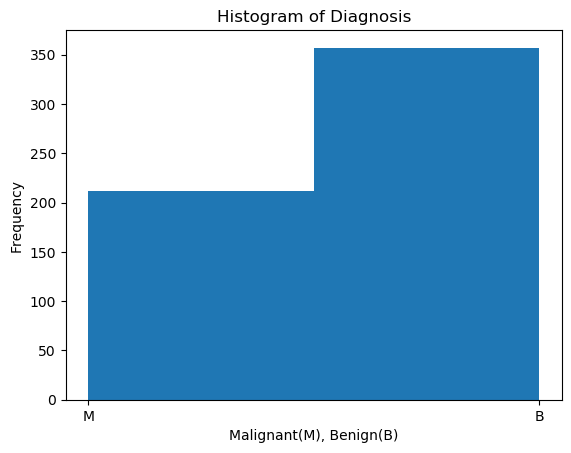

PyObject Text(24.000000000000007, 0.5, 'Frequency')

In [308]:
using PyPlot
PyPlot.plt.hist(df[:diagnosis], 2) 
plt.title("Histogram of Diagnosis")
plt.xlabel("Malignant(M), Benign(B)")
plt.ylabel("Frequency")

## Data Preprocessing

##### Converting the categorical feature "diagnosis" to integer by doing label encoding

In [356]:
df[:diagnosis]

569-element CSV.Column{String,PooledString}:
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 ⋮  
 "B"
 "B"
 "B"
 "B"
 "B"
 "M"
 "M"
 "M"
 "M"
 "M"
 "M"
 "B"

In [354]:
y = convertlabel(LabelEnc.MarginBased,df[:diagnosis])

569-element Array{Float64,1}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮  
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
 -1.0

In [364]:
using FreqTables
frequency_digonosis = freqtable(newdf[:diagnosis])

2-element Named Array{Int64,1}
Dim1  │ 
──────┼────
0     │ 357
1     │ 212

In [357]:
using MLLabelUtils
y = convertlabel(LabelEnc.MarginBased,df[:diagnosis])
y = classify.(y, LabelEnc.ZeroOne(Int,1))
newdf = copy(df)
deletecols!(newdf, :diagnosis)
newdf[:diagnosis] = y;

In [359]:
y

569-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 1
 0

In [360]:
#deletecols!(newdf, :id)

##### Dataset after encodning

In [361]:
first(newdf,5)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
,Int64,Float64,Float64,Float64,Float64,Float64
1,842302,17.99,10.38,122.8,1001.0,0.1184
2,842517,20.57,17.77,132.9,1326.0,0.08474
3,84300903,19.69,21.25,130.0,1203.0,0.1096
4,84348301,11.42,20.38,77.58,386.1,0.1425
5,84358402,20.29,14.34,135.1,1297.0,0.1003


##### Description of Dataset after encodning 

In [362]:
println(describe(newdf))

32×8 DataFrame
│ Row │ variable                │ mean       │ min       │ median   │ max       │ nunique │ nmissing │ eltype   │
│     │ Symbol                  │ Float64    │ Real      │ Float64  │ Real      │ Nothing │ Nothing  │ DataType │
├─────┼─────────────────────────┼────────────┼───────────┼──────────┼───────────┼─────────┼──────────┼──────────┤
│ 1   │ id                      │ 3.03718e7  │ 8670      │ 906024.0 │ 911320502 │         │          │ Int64    │
│ 2   │ radius_mean             │ 14.1273    │ 6.981     │ 13.37    │ 28.11     │         │          │ Float64  │
│ 3   │ texture_mean            │ 19.2896    │ 9.71      │ 18.84    │ 39.28     │         │          │ Float64  │
│ 4   │ perimeter_mean          │ 91.969     │ 43.79     │ 86.24    │ 188.5     │         │          │ Float64  │
│ 5   │ area_mean               │ 654.889    │ 143.5     │ 551.1    │ 2501.0    │         │          │ Float64  │
│ 6   │ smoothness_mean         │ 0.0963603  │ 0.05263   │ 0.09587  │ 0.1

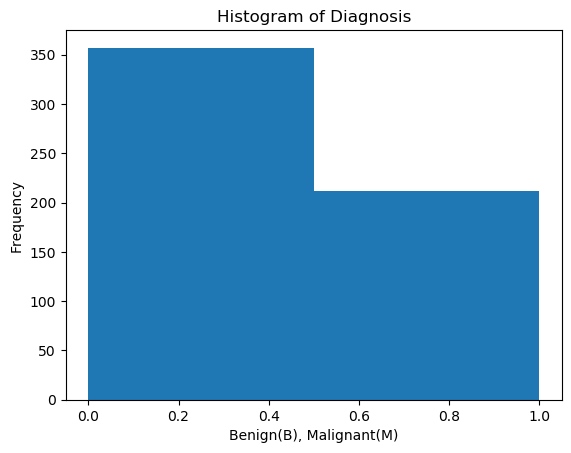

PyObject Text(24.000000000000007, 0.5, 'Frequency')

In [365]:
using PyPlot
PyPlot.plt.hist(newdf[:diagnosis], 2)
plt.title("Histogram of Diagnosis")
plt.xlabel("Benign(B), Malignant(M)")
plt.ylabel("Frequency")

# Spliting the dataset into train, test

##### Shuffling the Dataset

In [313]:
using MLDataUtils
newdf_s = shuffleobs(newdf);
first(newdf_s,10)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean
,Int64,Float64,Float64,Float64,Float64,Float64
1,88649001,19.55,28.77,133.6,1207.0,0.0926
2,8612080,12.0,15.65,76.95,443.3,0.09723
3,8810158,13.11,22.54,87.02,529.4,0.1002
4,889403,15.61,19.38,100.0,758.6,0.0784
5,894335,12.43,17.0,78.6,477.3,0.07557
6,871149,10.9,12.96,68.69,366.8,0.07515
7,86135501,14.48,21.46,94.25,648.2,0.09444
8,8810987,13.86,16.93,90.96,578.9,0.1026
9,864018,11.34,21.26,72.48,396.5,0.08759


##### Spliting into train and test

In [314]:
train, test = splitobs(newdf_s, at = 0.70);

##### Seperating the features and class label

In [315]:
row,col = size(train)

(398, 32)

In [316]:
X_train = convert(Matrix, train[:,2:col-1]);
y_train = convert(Matrix, train[:,col:col]);
X_test = convert(Matrix, test[:,2:col-1]);
y_test = convert(Matrix, test[:,col:col]);

##### Converting (n,1) dimension to (n, ) as per the classifiers requirements

In [317]:
y_train = vec(y_train);
y_test = vec(y_test);

# Applying algorithms to train models 

### RandomForest

##### Loading necessary packages

In [318]:
using DecisionTree

In [319]:
?RandomForestClassifier

search: RandomForestClassifier



```
RandomForestClassifier(; n_subfeatures::Int=-1,
                       n_trees::Int=10,
                       partial_sampling::Float=0.7,
                       max_depth::Int=-1,
                       rng=Random.GLOBAL_RNG)
```

Random forest classification. See [DecisionTree.jl's documentation](https://github.com/bensadeghi/DecisionTree.jl)

Hyperparameters:

  * `n_subfeatures`: number of features to consider at random per split (default: -1, sqrt(# features))
  * `n_trees`: number of trees to train (default: 10)
  * `partial_sampling`: fraction of samples to train each tree on (default: 0.7)
  * `max_depth`: maximum depth of the decision trees (default: no maximum)
  * `min_samples_leaf`: the minimum number of samples each leaf needs to have
  * `min_samples_split`: the minimum number of samples in needed for a split
  * `min_purity_increase`: minimum purity needed for a split
  * `rng`: the random number generator to use. Can be an `Int`, which will be used to seed and create a new random number generator.

Implements `fit!`, `predict`, `predict_proba`, `get_classes`


##### Creating an object of Classifier

In [320]:
using DecisionTree
using ScikitLearn: fit!, predict
rfc = RandomForestClassifier(n_trees = 110, n_subfeatures = 15, max_depth = 7);

##### Fitting the classifiers on training data samples

In [321]:
fit!(rfc, X_train, y_train);

##### predicting the test  data samples

In [322]:
y_pred_rfc = predict(rfc, X_test);
println("A portion of prediction:")
y_pred_rfc[1:10]

A portion of prediction:


10-element Array{Int64,1}:
 1
 0
 1
 1
 1
 0
 1
 1
 0
 0

In [323]:
cm  = confusion_matrix(y_test, y_pred_rfc)

2×2 Array{Int64,2}:
 105   3
   4  59

Classes:  [0, 1]
Matrix:   
Accuracy: 0.9590643274853801
Kappa:    0.9117451891174517

### AdaBoostClassifier

In [324]:
?AdaBoostStumpClassifier

search: AdaBoostStumpClassifier



```
AdaBoostStumpClassifier(; n_iterations::Int=0)
```

Adaboosted decision tree stumps. See [DecisionTree.jl's documentation](https://github.com/bensadeghi/DecisionTree.jl)

Hyperparameters:

  * `n_iterations`: number of iterations of AdaBoost
  * `rng`: the random number generator to use. Can be an `Int`, which will be used to seed and create a new random number generator.

Implements `fit!`, `predict`, `predict_proba`, `get_classes`


##### Parameter Tuning

In [325]:
using ScikitLearn.GridSearch: GridSearchCV

gridsearch = GridSearchCV(AdaBoostStumpClassifier(), Dict(:n_iterations => 1:1:100))
fit!(gridsearch, X_train, y_train)
println("Best parameters: $(gridsearch.best_params_)")

Best parameters: Dict{Symbol,Any}(:n_iterations=>89)


#####  Creating object of Random Forest

In [326]:
abc = AdaBoostStumpClassifier(n_iterations = 89);
fit!(abc, X_train, y_train);

In [327]:
y_pred_abc = predict(abc, X_test);
println("A portion of prediction:")
y_pred_abc[1:10]

A portion of prediction:


10-element Array{Int64,1}:
 1
 0
 1
 1
 1
 0
 1
 1
 0
 0

In [328]:
cm  = confusion_matrix(y_test, y_pred_abc)

2×2 Array{Int64,2}:
 105   3
   3  60

Classes:  [0, 1]
Matrix:   
Accuracy: 0.9649122807017544
Kappa:    0.9246031746031746

In [329]:
?DecisionTreeClassifier

search: DecisionTreeClassifier



```
DecisionTreeClassifier(; pruning_purity_threshold=0.0,
                       max_depth::Int=-1,
                       min_samples_leaf::Int=1,
                       min_samples_split::Int=2,
                       min_purity_increase::Float=0.0,
                       n_subfeatures::Int=0,
                       rng=Random.GLOBAL_RNG)
```

Decision tree classifier. See [DecisionTree.jl's documentation](https://github.com/bensadeghi/DecisionTree.jl)

Hyperparameters:

  * `pruning_purity_threshold`: (post-pruning) merge leaves having `>=thresh` combined purity (default: no pruning)
  * `max_depth`: maximum depth of the decision tree (default: no maximum)
  * `min_samples_leaf`: the minimum number of samples each leaf needs to have (default: 1)
  * `min_samples_split`: the minimum number of samples in needed for a split (default: 2)
  * `min_purity_increase`: minimum purity needed for a split (default: 0.0)
  * `n_subfeatures`: number of features to select at random (default: keep all)
  * `rng`: the random number generator to use. Can be an `Int`, which will be used to seed and create a new random number generator.

Implements `fit!`, `predict`, `predict_proba`, `get_classes`


In [330]:
dtc = DecisionTreeClassifier()
fit!(dtc, X_train, y_train);
y_pred_dtc = predict(dtc, X_test);
println("A portion of prediction:")
y_pred_dtc[1:10]

A portion of prediction:


10-element Array{Int64,1}:
 1
 0
 1
 1
 1
 0
 1
 1
 0
 0

In [331]:
cm  = confusion_matrix(y_test, y_pred_dtc)

2×2 Array{Int64,2}:
 103   5
   4  59

Classes:  [0, 1]
Matrix:   
Accuracy: 0.9473684210526315
Kappa:    0.8872775214238627

### XGBoost

In [332]:
#import Pkg; 
#Pkg.add("XGBoost")

In [333]:
using XGBoost

In [334]:
?xgboost

search: xgboost XGBoost



No documentation found.

`XGBoost.xgboost` is a `Function`.

```
# 1 method for generic function "xgboost":
[1] xgboost(data, nrounds::Integer; label, param, watchlist, metrics, obj, feval, group, kwargs...) in XGBoost at C:\Users\idpau\.julia\packages\XGBoost\LXjD0\src\xgboost_lib.jl:145
```


In [335]:
num_round = 5
xgbc = xgboost(X_train, num_round, label = y_train, eta = 1, max_depth = 2)

[1]	train-rmse:0.198602
[2]	train-rmse:0.176235
[3]	train-rmse:0.169523
[4]	train-rmse:0.147972
[5]	train-rmse:0.142516


Booster(Ptr{Nothing} @0x0000000030c6d870)

In [336]:
y_pred_xgbc = XGBoost.predict(xgbc, X_test)
print("test-error=", sum((y_pred_xgbc .> 0.5) .!= y_test) / float(size(y_pred_xgbc)[1]), "\n")

test-error=0.05263157894736842


In [337]:
y_pred_xgbc

171-element Array{Float32,1}:
  0.53978115 
 -0.25779533 
  1.0317149  
  1.0317149  
  1.0317149  
  0.010956287
  0.45978114 
  1.0317149  
 -0.031113505
  0.05084306 
  0.010956287
 -0.310997   
  0.061974943
  ⋮          
  0.061974943
  0.9918282  
  0.05084306 
 -0.031113505
 -0.042245388
  1.0317149  
  0.061974943
  0.05084306 
 -0.042245388
 -0.042245388
  1.0317149  
  1.0317149  

In [338]:
cm  = confusion_matrix(y_test, y_pred_xgbc[0])

BoundsError: BoundsError: attempt to access 171-element Array{Float32,1} at index [0]

# Performance and Results

### Performance evaluation criteria

##### Defining functions for calculating different performance metrices

In [339]:
using PyCall
math = pyimport("math")

function accuracy_(tn,fp,fn,tp)
    return ((tp+tn)/(tp+fp+fn+tn))
end

#True Positive Rate or Recall
function sensitivity(tp,fn)
    return (tp / (tp + fn))
end

tprate = sensitivity
recall = sensitivity

#True Negative Rate
function specificity(tn,fp)
    return (tn / (fp + tn))
end

function mcc(tn,fp,fn,tp)
    return (tp*tn-fp*fn)/math.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
end

function auc_score(tn,fp,fn,tp)
    return (sensitivity(tp,fn) + specificity(tn,fp)) / 2
end

function gmean_score(tn,fp,fn,tp)
    return math.sqrt(sensitivity(tp,fn) * specificity(tn,fp))
end

function precision(tp, fp)
    return (tp / (tp + fp))
end

function f1score(tp, fp, fn)
    return (2*tp/(2*tp + fp + fn))
end

function fprate(tn,fp)
    return (fp / (fp + tn))
end

fprate (generic function with 1 method)

##### Definfing a function for producing all scores at once.

In [340]:
function getAllScore(tp,tn,fp,fn)
    acc = accuracy_(tn,fp,fn,tp)
    sn = sensitivity(tp,fn)
    sp = specificity(tn,fp)
    auc = auc_score(tn,fp,fn,tp)
    gmean = gmean_score(tn,fp,fn,tp)
    preci = precision(tp, fp)
    f1 = f1score(tp,fp,fn)
    fpr = fprate(tn,fp)
    return acc, sn, sp, auc, gmean, preci, f1, fpr
end

getAllScore (generic function with 1 method)

### Result of RandomForest

#### Loading MLBase to compute roc performance parameter 

In [341]:
using MLBase
r_rfc = roc(y_test, y_pred_rfc)

ROCNums{Int64}
  p = 63
  n = 108
  tp = 59
  tn = 105
  fp = 3
  fn = 4


##### Calling the getAllScore function

In [342]:
allScoresTuples = getAllScore(r_rfc.tp, r_rfc.tn, r_rfc.fp, r_rfc.fn)
allScoresArray = [i for i in allScoresTuples]
allScores = transpose(allScoresArray)

1×8 LinearAlgebra.Transpose{Float64,Array{Float64,1}}:
 0.959064  0.936508  0.972222  0.954365  0.954198  0.951613  0.944  0.0277778

In [343]:
?CSV.write

```
CSV.write(file, table; kwargs...) => file
table |> CSV.write(file; kwargs...) => file
```

Write a [Tables.jl interface input](https://github.com/JuliaData/Tables.jl) to a csv file, given as an `IO` argument or `String`/FilePaths.jl type representing the file name to write to.

Supported keyword arguments include:

  * `delim::Union{Char, String}=','`: a character or string to print out as the file's delimiter
  * `quotechar::Char='"'`: ascii character to use for quoting text fields that may contain delimiters or newlines
  * `openquotechar::Char`: instead of `quotechar`, use `openquotechar` and `closequotechar` to support different starting and ending quote characters
  * `escapechar::Char='"'`: ascii character used to escape quote characters in a text field
  * `missingstring::String=""`: string to print for `missing` values
  * `dateformat=Dates.default_format(T)`: the date format string to use for printing out `Date` & `DateTime` columns
  * `append=false`: whether to append writing to an existing file/IO, if `true`, it will not write column names by default
  * `writeheader=!append`: whether to write an initial row of delimited column names, not written by default if appending
  * `header`: pass a list of column names (Symbols or Strings) to use instead of the column names of the input table
  * `newline='\n'`: character or string to use to separate rows (lines in the csv file)
  * `quotestrings=false`: whether to force all strings to be quoted or not
  * `decimal='.'`: character to use as the decimal point when writing floating point numbers


In [344]:
allScoresArray

8-element Array{Float64,1}:
 0.9590643274853801  
 0.9365079365079365  
 0.9722222222222222  
 0.9543650793650793  
 0.9541980020732038  
 0.9516129032258065  
 0.944               
 0.027777777777777776

##### Storing the all scores into a dataframe

In [345]:
columnNames = ["accuracy", "sensitivity", "specificity", "auc", "gmean", "precision", "f1_score", "fpr"]
resultDF = DataFrame(allScores, Symbol.(columnNames), )

,accuracy,sensitivity,specificity,auc,gmean,precision,f1_score,fpr
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.959064,0.936508,0.972222,0.954365,0.954198,0.951613,0.944,0.0277778


### Result of AdaBoost

In [346]:
using MLBase
r_abc = roc(y_test, y_pred_abc)

ROCNums{Int64}
  p = 63
  n = 108
  tp = 60
  tn = 105
  fp = 3
  fn = 3


##### Calling the getAllScore function

In [347]:
allScoresTuples = getAllScore(r_abc.tp, r_abc.tn, r_abc.fp, r_abc.fn)
allScoresArray = [i for i in allScoresTuples]
allScores = transpose(allScoresArray)

1×8 LinearAlgebra.Transpose{Float64,Array{Float64,1}}:
 0.964912  0.952381  0.972222  0.962302  …  0.952381  0.952381  0.0277778

In [348]:
allScoresArray

8-element Array{Float64,1}:
 0.9649122807017544  
 0.9523809523809523  
 0.9722222222222222  
 0.9623015873015872  
 0.9622504486493763  
 0.9523809523809523  
 0.9523809523809523  
 0.027777777777777776

##### Storing the all scores into a dataframe

In [349]:
columnNames = ["accuracy", "sensitivity", "specificity", "auc", "gmean", "precision", "f1_score", "fpr"]
resultDF = DataFrame(allScores, Symbol.(columnNames), )

,accuracy,sensitivity,specificity,auc,gmean,precision,f1_score,fpr
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.964912,0.952381,0.972222,0.962302,0.96225,0.952381,0.952381,0.0277778


# Drawing a ROC curve with auc score

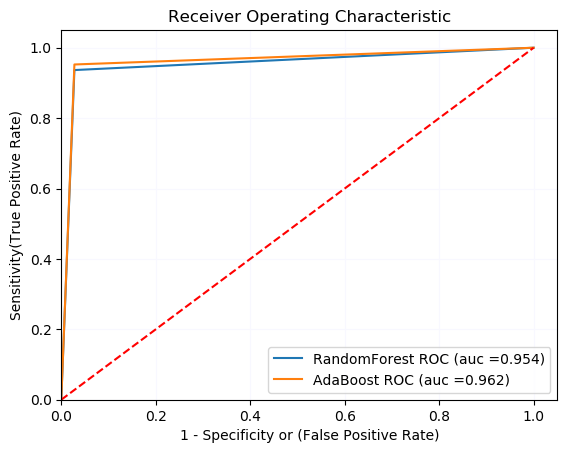

In [350]:
fprArr = [0, fprate(r_rfc.tn,r_rfc.fp), 1]
tprArr = [0, tprate(r_rfc.tp,r_rfc.fn), 1]
auc_ = round(auc_score(r_rfc.tn,r_rfc.fp,r_rfc.fn,r_rfc.tp), digits=3)
plt.plot(fprArr,tprArr,label= string( "RandomForest", " ROC (auc =", auc_, ")" ) )

fprArr = [0, fprate(r_abc.tn,r_abc.fp), 1]
tprArr = [0, tprate(r_abc.tp,r_abc.fn), 1]
auc_ = round(auc_score(r_abc.tn,r_abc.fp,r_abc.fn,r_abc.tp), digits=3)
plt.plot(fprArr,tprArr,label= string( "AdaBoost", " ROC (auc =", auc_, ")" ) )

xlabel("1 - Specificity or (False Positive Rate)")
ylabel("Sensitivity(True Positive Rate)")
plt.plot([0, 1], [0, 1],"r--")
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
PyPlot.title("Receiver Operating Characteristic")
grid("on")
legend()
#plt.savefig("roc_curve.png",bbox_inches="tight", format="png", dpi=1200)
#plt.show()   # Display
plt.grid(color="ghostwhite")
plt.savefig("new_roc.png",bbox_inches="tight", format="png", dpi=1200, transparent=1)
plt.show()   # Display

In [351]:
?xlabel

search: xlabel




        Set the label for the x-axis.

        Parameters
        ----------
        xlabel : str
            The label text.

        labelpad : scalar, optional, default: None
            Spacing in points from the axes bounding box including ticks
            and tick labels.

        Other Parameters
        ----------------
        **kwargs : `.Text` properties
            `.Text` properties control the appearance of the label.

        See also
        --------
        text : for information on how override and the optional args work
        

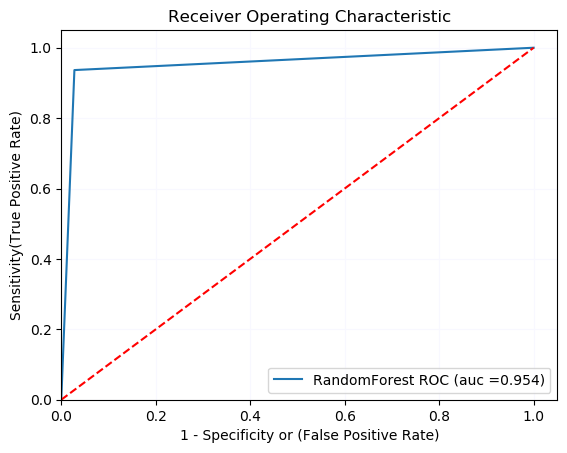

In [352]:
fprArr = [0, fprate(r_rfc.tn,r_rfc.fp), 1]
tprArr = [0, tprate(r_rfc.tp,r_rfc.fn), 1]
auc_ = round(auc_score(r_rfc.tn,r_rfc.fp,r_rfc.fn,r_rfc.tp), digits=3)
plt.plot(fprArr,tprArr,label= string( "RandomForest", " ROC (auc =", auc_, ")" ) )

xlabel("1 - Specificity or (False Positive Rate)")
ylabel("Sensitivity(True Positive Rate)")
plt.plot([0, 1], [0, 1],"r--")
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
PyPlot.title("Receiver Operating Characteristic")
grid("on")
legend()
#plt.savefig("roc_curve.png",bbox_inches="tight", format="png", dpi=1200)
#plt.show()   # Display
plt.grid(color="ghostwhite")
plt.savefig("new_roc_rfc.png",bbox_inches="tight", format="png", dpi=1200, transparent=1)
plt.show()   # Display